"""
---
title: Fixed Positional Encodings
summary: >
  Implementation with explanation of fixed positional encodings as
  described in paper Attention is All You Need.
---

# Fixed Positional Encodings

The positional encoding encodes the position along the sequence into
 a vector of size `d_model`.

\begin{align}
PE_{p,2i} &= sin\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg) \\
PE_{p,2i + 1} &= cos\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg)
\end{align}

Where $1 \leq 2i, 2i + 1 \leq d_{model}$
 are the feature indexes in the encoding, and $p$ is the position.
"""


torch.Size([100, 2, 20])


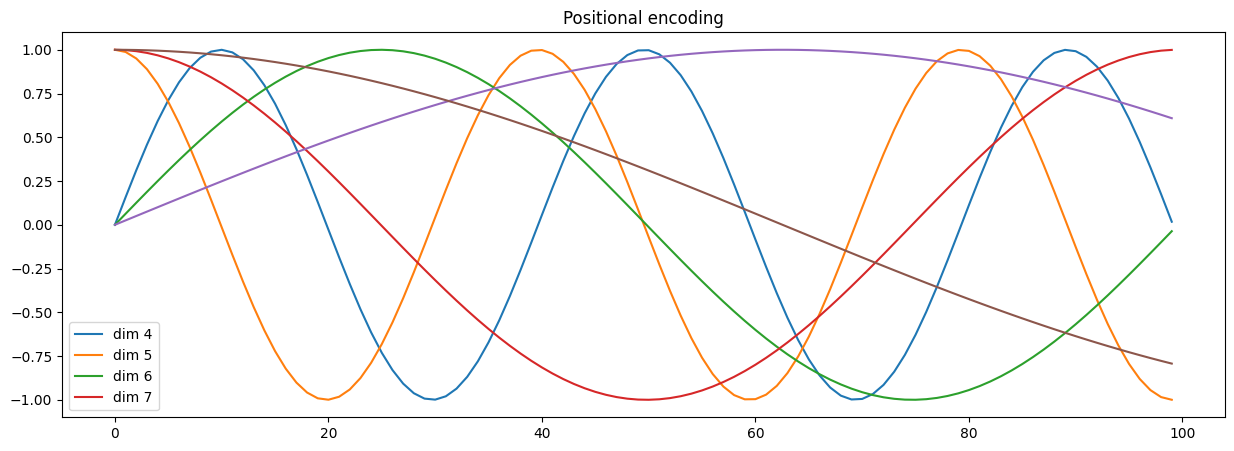

In [18]:
import math

import numpy as np
import torch
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout_prob: float, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)
        # register_buffer 表示变量会存储到模型参数中，但是不会随着梯度下降更新
        self.register_buffer('positional_encodings', get_positional_encoding(d_model, max_len), False)

    def forward(self, x: torch.Tensor):
        pe = self.positional_encodings[:x.shape[0]].detach().requires_grad_(False)
        x = x + pe
        x = self.dropout(x)
        return x


def get_positional_encoding(d_model: int, max_len: int = 5000):
    # Empty encodings vectors
    encodings = torch.zeros(max_len, d_model)
    # Position indexes
    # 对于seq中的编码是position，对于d_model中的编码是i
    position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
    # $2 * i$
    two_i = torch.arange(0, d_model, 2, dtype=torch.float32)
    # $10000^{\frac{2i}{d_{model}}}$
    # shape (two_i, )
    div_term = torch.exp(two_i * -(math.log(10000.0) / d_model))
    # $PE_{p,2i} = sin\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg)$
    # 广播机制(100,1)*(10,1)变成(100,10)
    # 从0开始，每次跳两个, :: 表示跳着读
    encodings[:, 0::2] = torch.sin(position * div_term)
    # $PE_{p,2i + 1} = cos\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg)$
    encodings[:, 1::2] = torch.cos(position * div_term)

    # Add batch dimension
    encodings = encodings.unsqueeze(1).requires_grad_(False)

    return encodings


def _test_positional_encoding():
    import matplotlib.pyplot as plt
    p = torch.randn([100,2,20])
    
    # 设置大小->画x、y轴->写线的名字->写表的名字->展示
    plt.figure(figsize=(15, 5))
    pe = get_positional_encoding(20, 100)
    print((p + pe).shape)
    plt.plot(np.arange(100), pe[:, 0, 4:8].numpy())
    plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])
    plt.title("Positional encoding")
    plt.show()


if __name__ == '__main__':
    _test_positional_encoding()
